<a href="https://colab.research.google.com/github/chxnmay17/SPPU-ML-Laboratory/blob/main/pract1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Starting Task 1: Pre-processing Dataset ---
Initial dataset shape: (200000, 9)
Missing values before dropping: 2
Shape after dropping NaNs: (199999, 7)

--- Starting Task 2: Identifying and Removing Outliers ---
Shape before fare_amount filter: (199999, 7)
Shape after fare_amount filter: (199975, 7)
Shape before passenger_count filter: (199975, 7)
Shape after passenger_count filter: (199266, 7)
Shape before coordinate filter: (199266, 7)
Shape after coordinate filter: (194953, 7)

--- Starting Feature Engineering ---
Shape before 0-distance filter: (194953, 7)
Shape after 0-distance filter: (192514, 7)
Dataset is large (192514 rows). Sampling 100,000 rows.

Final pre-processed data head:
        fare_amount  passenger_count  distance_km  hour  day_of_week  month  \
172289          8.0                1     1.241872     9            1      5   
25693           5.7                1     2.102542     2            3     11   
75             17.3                4     6.100532     4       

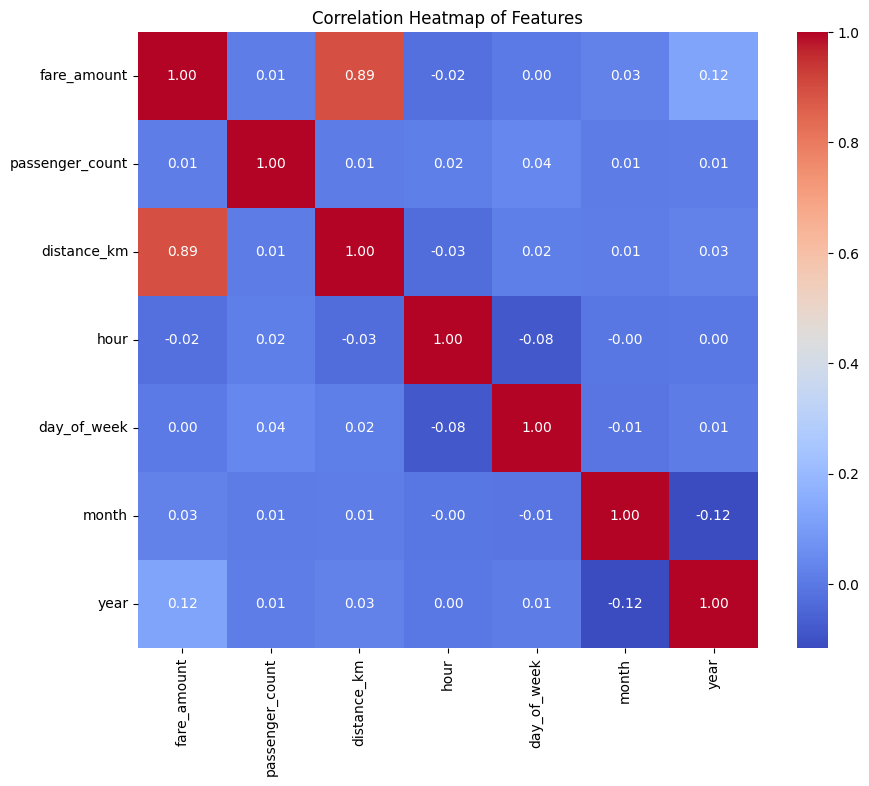

Generated correlation heatmap.

--- Starting Task 4: Model Implementation ---
Training Linear Regression model...
Linear Regression training complete.
Training Random Forest Regression model...
Random Forest training complete.

--- Starting Task 5: Model Evaluation ---

--- Linear Regression Performance ---
R-squared (R2): 0.8055
Root Mean Squared Error (RMSE): 4.2087

--- Random Forest Performance ---
R-squared (R2): 0.8233
Root Mean Squared Error (RMSE): 4.0120

--- Model Comparison ---
            Model  R-squared (R2)     RMSE
Linear Regression        0.805533 4.208743
    Random Forest        0.823289 4.012004

The Random Forest model performed better (higher R2 score and lower RMSE).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# -----------------------------------------------------------------
# Task 1: Pre-process the dataset
# -----------------------------------------------------------------

print("--- Starting Task 1: Pre-processing Dataset ---")

# Load the dataset
try:
    df = pd.read_csv('uber.csv')
except FileNotFoundError:
    print("Error: 'uber.csv' not found. Please upload the file using the Colab sidebar.")
    raise

print(f"Initial dataset shape: {df.shape}")

# Drop irrelevant columns. 'Unnamed: 0' is the old index, and 'key' seems
# to be a redundant datetime or ID.
df.drop(columns=['Unnamed: 0', 'key'], inplace=True, errors='ignore')

# Handle missing values
print(f"Missing values before dropping: {df.isnull().sum().sum()}")
df.dropna(inplace=True)
print(f"Shape after dropping NaNs: {df.shape}")

# Convert 'pickup_datetime' to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# -----------------------------------------------------------------
# Task 2: Identify and remove outliers
# -----------------------------------------------------------------
print("\n--- Starting Task 2: Identifying and Removing Outliers ---")

# 1. Fare Amount
# Fares must be positive. Let's also set a reasonable upper bound, e.g., $300.
print(f"Shape before fare_amount filter: {df.shape}")
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] <= 300)]
print(f"Shape after fare_amount filter: {df.shape}")

# 2. Passenger Count
# Passengers should be between 1 and 6 (for a standard car).
print(f"Shape before passenger_count filter: {df.shape}")
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]
print(f"Shape after passenger_count filter: {df.shape}")

# 3. Coordinates
# Filter to a reasonable bounding box for NYC.
# Lat (40.5 to 41.0), Lon (-74.5 to -73.5)
print(f"Shape before coordinate filter: {df.shape}")
df = df[(df['pickup_latitude'] >= 40.5) & (df['pickup_latitude'] <= 41.0)]
df = df[(df['pickup_longitude'] >= -74.5) & (df['pickup_longitude'] <= -73.5)]
df = df[(df['dropoff_latitude'] >= 40.5) & (df['dropoff_latitude'] <= 41.0)]
df = df[(df['dropoff_longitude'] >= -74.5) & (df['dropoff_longitude'] <= -73.5)]
print(f"Shape after coordinate filter: {df.shape}")

# --- Feature Engineering (part of pre-processing) ---
print("\n--- Starting Feature Engineering ---")

# 1. Calculate distance using the Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of Earth in kilometers.
    r = 6371
    return c * r

df['distance_km'] = haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

# 2. Extract features from 'pickup_datetime'
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

# 3. Drop original columns that are no longer needed
df.drop(['pickup_datetime', 'pickup_latitude', 'pickup_longitude',
         'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)

# 4. Remove trips with 0 distance, which are likely errors
print(f"Shape before 0-distance filter: {df.shape}")
df = df[df['distance_km'] > 0.01]
print(f"Shape after 0-distance filter: {df.shape}")

# --- Handle Large Dataset: Sub-sample ---
# Running RF on the full dataset (if large) can be very slow.
# We'll cap it at 100,000 rows for this practical.
if len(df) > 100000:
    print(f"Dataset is large ({len(df)} rows). Sampling 100,000 rows.")
    df = df.sample(n=100000, random_state=42)
else:
    print("Dataset is of a manageable size.")

print(f"\nFinal pre-processed data head:\n{df.head()}")

# -----------------------------------------------------------------
# Task 3: Check the correlation
# -----------------------------------------------------------------
print("\n--- Starting Task 3: Correlation Check ---")

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show() # Use plt.show() to display in Colab
print("Generated correlation heatmap.")

# -----------------------------------------------------------------
# Task 4: Implement Linear Regression and Random Forest
# -----------------------------------------------------------------
print("\n--- Starting Task 4: Model Implementation ---")

# Define features (X) and target (y)
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Scale the data ---
# Scaling is crucial for Linear Regression. It doesn't hurt Random Forest.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Model 1: Linear Regression ---
print("Training Linear Regression model...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression training complete.")

# --- Model 2: Random Forest Regression ---
print("Training Random Forest Regression model...")
# We use n_estimators=100 for a robust model, and n_jobs=-1
# to use all available CPU cores for faster training.
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(X_train_scaled, y_train)
y_pred_rfr = rfr.predict(X_test_scaled)
print("Random Forest training complete.")

# -----------------------------------------------------------------
# Task 5: Evaluate the models and compare scores
# -----------------------------------------------------------------
print("\n--- Starting Task 5: Model Evaluation ---")

# --- Linear Regression Evaluation ---
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("\n--- Linear Regression Performance ---")
print(f"R-squared (R2): {r2_lr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")

# --- Random Forest Evaluation ---
r2_rfr = r2_score(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))

print("\n--- Random Forest Performance ---")
print(f"R-squared (R2): {r2_rfr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rfr:.4f}")

# --- Comparison ---
print("\n--- Model Comparison ---")
results = {
    'Model': ['Linear Regression', 'Random Forest'],
    'R-squared (R2)': [r2_lr, r2_rfr],
    'RMSE': [rmse_lr, rmse_rfr]
}
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False)) # .to_string() formats it nicely

if r2_rfr > r2_lr:
    print("\nThe Random Forest model performed better (higher R2 score and lower RMSE).")
else:
    print("\nThe Linear Regression model performed better (higher R2 score and lower RMSE).")